# Importing Libraries

In [ ]:
# scientific computations 
import numpy as np

# data manipulation and transformation
import pandas as pd

# visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# model building
from sklearn.preprocessing import StandardScaler
from statsmodels.discrete.discrete_model import Logit
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
import statsmodels.tools as sm
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.metrics import *
from sklearn.tree import *
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,TimeSeriesSplit

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Preprocessing

In [ ]:
# importing the data and making a DataFrame 
loan_data = pd.read_excel("loan.xlsx")

In [ ]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [ ]:
# converting dependent variable "Loan_Status" to 1s and 0s
loan_data['Loan_Status'] = np.where(loan_data['Loan_Status']=='Y',1,0)

In [ ]:
# replacing 3+ with 3 to make a "Dependents" variable an intiger for further analysis 
loan_data.Dependents = np.where(loan_data.Dependents=="3+",3,loan_data.Dependents)

In [ ]:
# getting rid of "Loan_ID," since it wont affect whether a person will get a loan or not
del loan_data["Loan_ID"]

In [ ]:
# checking for duplicates, missing values, and single valued columns
# wee see that we have 149 missing values
print("Duplicates:", loan_data.duplicated().sum())
print("Missing values:", loan_data.isna().sum().sum())
print("Single valued columns:", loan_data.columns[loan_data.nunique()==1])

Duplicates: 0
Missing values: 149
Single valued columns: Index([], dtype='object')


In [ ]:
# since we didn't have a "lot of" missing values, instead of dropping them, we imputed mean value of the data 
# not to alter our statistics
# NaNs for categorical variables were substituted and then dropped for getting more precise results while 
# conducting the analysis
# in case of dropping all 149 NaNs we would end up having 460 entries instead of 566
loan_data.fillna(loan_data.mean(), inplace=True)
loan_data["Gender"].fillna("No Gender", inplace = True) 
loan_data.drop(loan_data.index[loan_data['Gender']=="No Gender"], inplace = True)
loan_data["Married"].fillna("Don't know", inplace = True) 
loan_data.drop(loan_data.index[loan_data['Married']=="Don't know"], inplace = True)
loan_data["Self_Employed"].fillna("Don't know", inplace = True) 
loan_data.drop(loan_data.index[loan_data['Self_Employed']=="Don't know"], inplace = True)

In [ ]:
# checking for missing values one more time 
# now we have none
print("Missing values:", loan_data.isna().sum().sum())

Missing values: 0


In [ ]:
# deviding dataet into numbers and objects for further usage
data_num = loan_data.select_dtypes(exclude="object")
data_obj = loan_data.select_dtypes(include="object")

# Descriptive Analytics

In [ ]:
# dataset overview
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 566 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             566 non-null    object 
 1   Married            566 non-null    object 
 2   Dependents         566 non-null    float64
 3   Education          566 non-null    object 
 4   Self_Employed      566 non-null    object 
 5   ApplicantIncome    566 non-null    int64  
 6   CoapplicantIncome  566 non-null    float64
 7   LoanAmount         566 non-null    float64
 8   Loan_Amount_Term   566 non-null    float64
 9   Credit_History     566 non-null    float64
 10  Property_Area      566 non-null    object 
 11  Loan_Status        566 non-null    int64  
dtypes: float64(5), int64(2), object(5)
memory usage: 57.5+ KB


In [ ]:
# viewing first 5 rows of the dataset
loan_data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0.0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,1
1,Male,Yes,1.0,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,0
2,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,1
3,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,1
4,Male,No,0.0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,1


In [ ]:
# summary statistics
loan_data.describe()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
count,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000
mean,0.759992,5259.971731,1579.146502,144.541066,342.201413,0.837835,0.685512
std,1.000062,5412.901682,2507.243865,80.420869,64.699018,0.354956,0.464722
min,0.000000,150.000000,0.000000,9.000000,12.000000,0.000000,0.000000
25%,0.000000,2877.500000,0.000000,100.000000,360.000000,1.000000,0.000000
50%,0.000000,3839.500000,1149.000000,128.000000,360.000000,1.000000,1.000000
75%,1.000000,5811.250000,2297.250000,165.000000,360.000000,1.000000,1.000000
max,3.000000,81000.000000,33837.000000,650.000000,480.000000,1.000000,1.000000


In [ ]:
# counting the benchmark for getting a loan 
# 68.6% of customers get a loan, meaning that the new customer most probably 
# will be classified as 1 
loan_data.Loan_Status.value_counts(normalize=True).mul(100).rename("Loan percentage")

1    68.551237
0    31.448763
Name: Loan percentage, dtype: float64

In [ ]:
# viewing how many unique values there are in the data
loan_data.nunique()

Gender                 2
Married                2
Dependents             5
Education              2
Self_Employed          2
ApplicantIncome      473
CoapplicantIncome    273
LoanAmount           195
Loan_Amount_Term      11
Credit_History         3
Property_Area          3
Loan_Status            2
dtype: int64

# Data Visualization 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


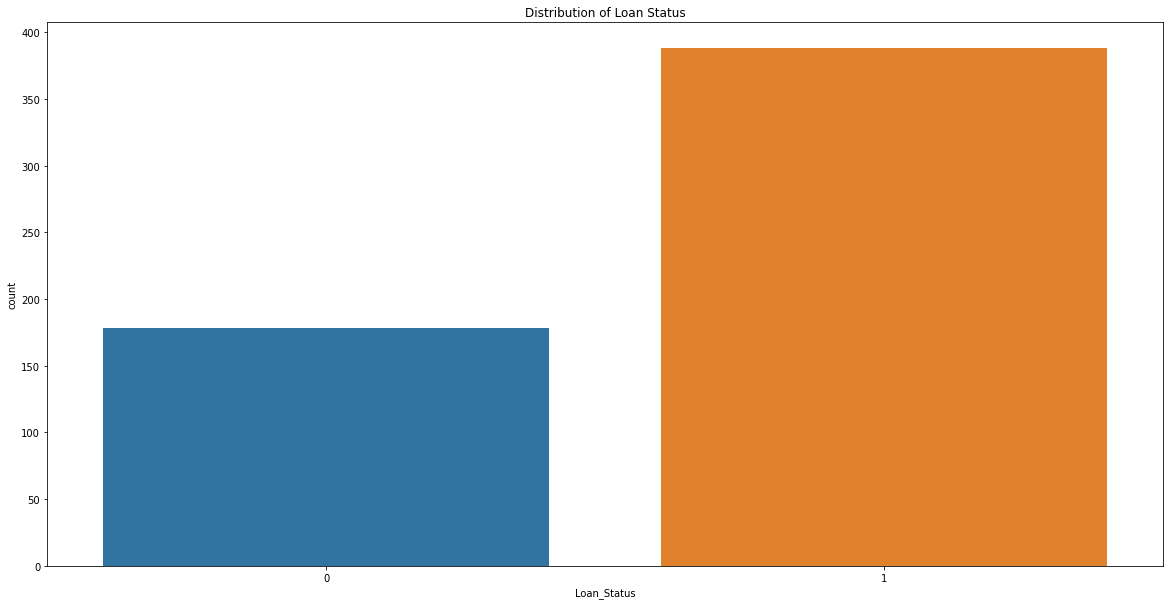

In [ ]:
# visualizing distribution of our dependent variable
plt.figure(figsize=(20,10))
sns.countplot(loan_data.Loan_Status)
plt.title("Distribution of Loan Status")
plt.show()

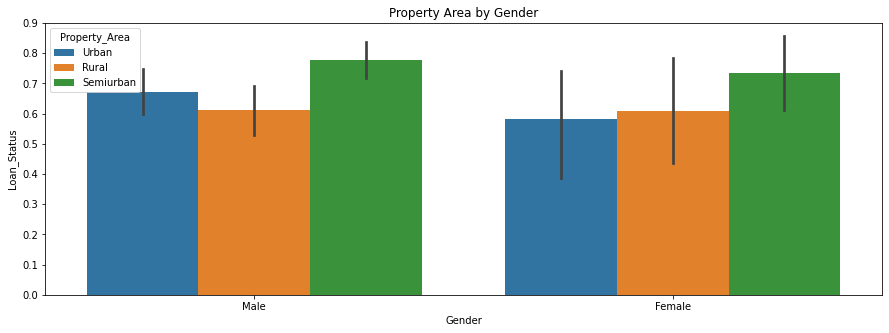

In [ ]:
# visualizing property area by gender 
plt.figure(figsize=(15,5))
sns.barplot(x="Gender", y="Loan_Status", hue="Property_Area", data=loan_data)
plt.title("Property Area by Gender")
plt.show()

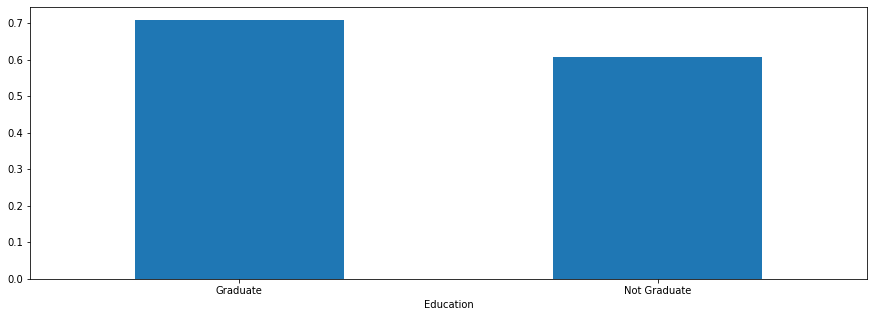

In [ ]:
# visualizing Loan_Status by Education
loan_data.groupby(by="Education")["Loan_Status"].mean().plot(kind='bar', figsize=(15,5), rot=0)

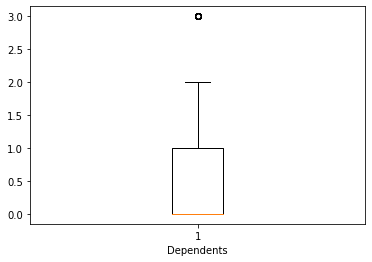

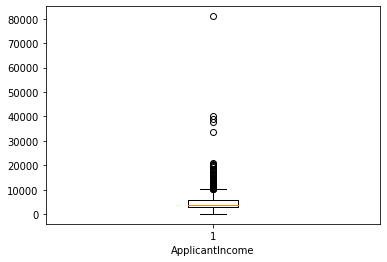

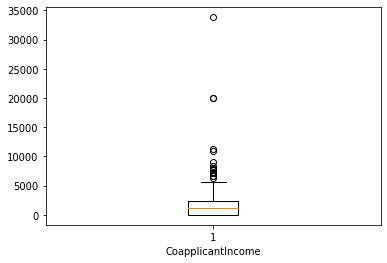

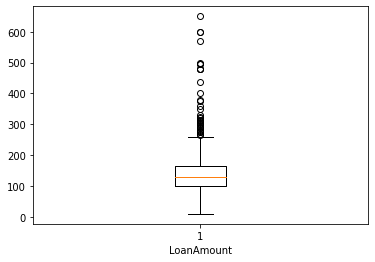

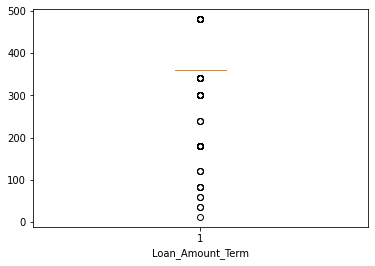

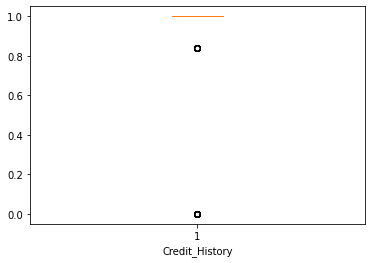

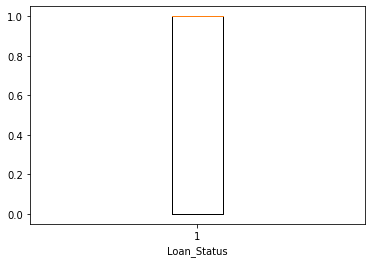

In [ ]:
# visualizing boxplots for numerical variables
for i in data_num.columns.tolist():
    plt.boxplot(loan_data[i])
    plt.xlabel(i)
    plt.show()

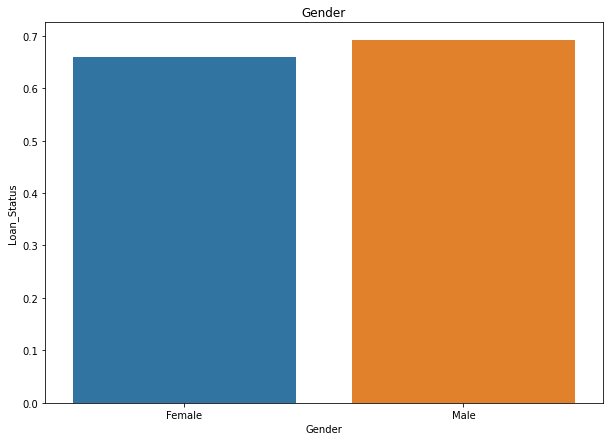

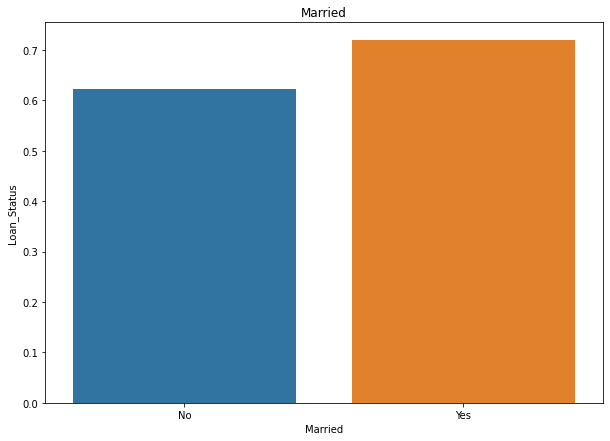

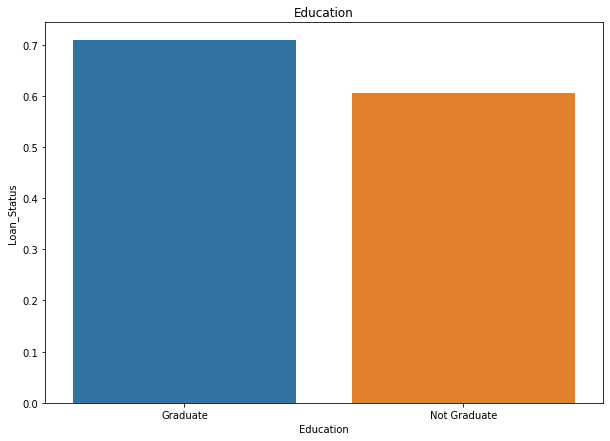

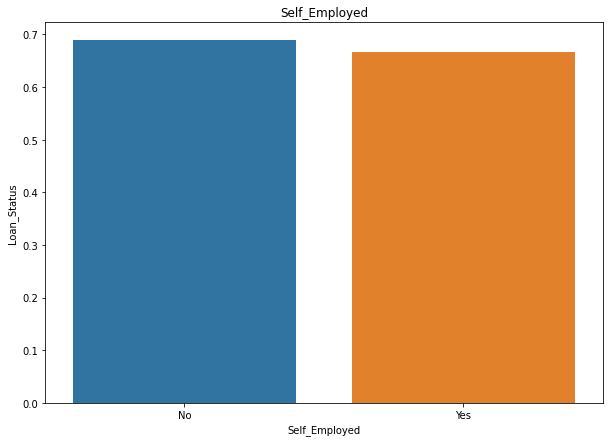

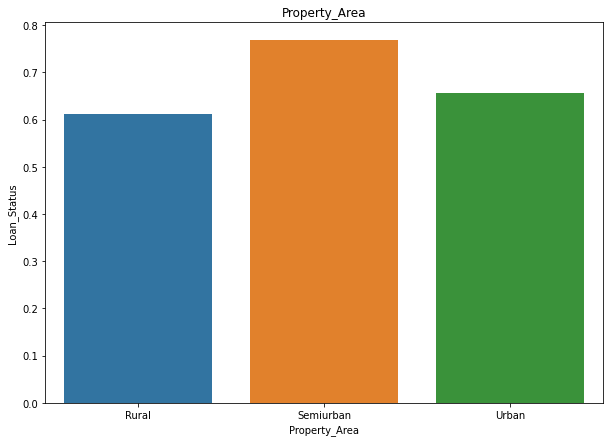

In [ ]:
# visualizing Loan_Status for categorical variables 
for i in data_obj:
    loan_status=pd.pivot_table(loan_data,index = [i],values = 'Loan_Status',aggfunc='mean').reset_index()
    plt.figure(figsize = (10,7))
    sns.barplot(x=loan_status.iloc[:,0], y=loan_status.iloc[:,1])
    plt.title(i)
    plt.ylabel('Loan_Status')
    plt.show()

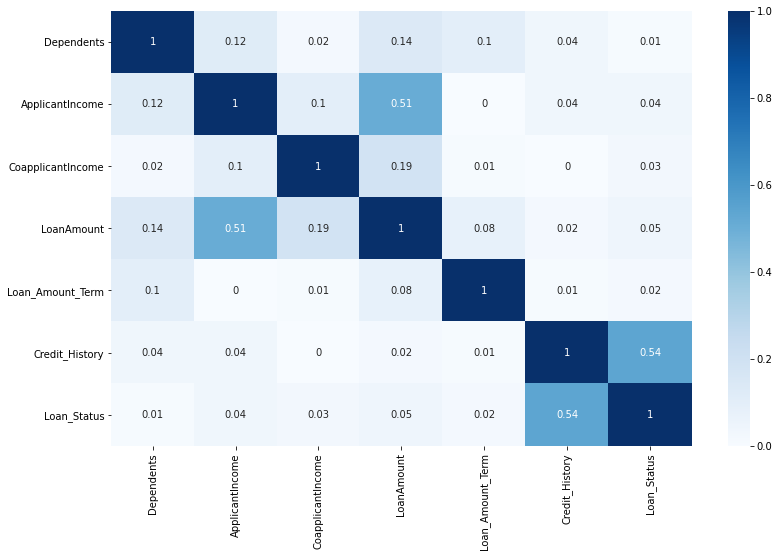

In [ ]:
# visualizing correlations
# correlation between ApplicantIncome and LoanAmount and Credit_History and Loan_Status is 
# 0.51 and 0.54 respectively
# normally we would drop one variable per each pair, however this is self-explanatory that 
# these variables should be related
plt.figure(figsize=(13,8))
sns.heatmap(loan_data.corr().abs().round(2),annot=True, cmap = "Blues")

# Model Building

In [ ]:
# creating a subset of potentially useful variables for the model. 
data = loan_data[["Dependents", "ApplicantIncome","CoapplicantIncome","LoanAmount","Loan_Amount_Term","Credit_History","Gender","Married","Education",
                   "Self_Employed","Property_Area", "Loan_Status"]]

In [ ]:
# creating different datasets for numbers and objects for further usage 
data_num = data.select_dtypes(exclude="object")
data_obj = data.select_dtypes(include="object")

In [ ]:
# getting dummy variables for objects and combining them with numbers
data_dummies = pd.get_dummies(data_obj, prefix=data_obj.columns,drop_first=True)
data = data_num.join(data_dummies)

Model 1 | Logistic Regression with Statsmodels


In [ ]:
# defining dependent and independent variables
Y = data["Loan_Status"]
X = data[["Dependents", "ApplicantIncome","CoapplicantIncome","LoanAmount","Loan_Amount_Term","Credit_History","Gender_Male","Married_Yes","Education_Not Graduate",
                   "Self_Employed_Yes","Property_Area_Semiurban", "Property_Area_Urban"]]

In [ ]:
# checking shape of X: 566 observations, and 12 independent variables
X.shape

(566, 12)

In [ ]:
# splitting the data into train and test (25% threshold)
X0, X1, Y0, Y1 = train_test_split(X, Y, test_size = 0.25, random_state=42)

In [ ]:
# building and fitting Logistic Regression Model 1
model1 = Logit(Y0, X0)
results = model1.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.465686
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            Loan_Status   No. Observations:                  424
Model:                          Logit   Df Residuals:                      412
Method:                           MLE   Df Model:                           11
Date:                Mon, 17 May 2021   Pseudo R-squ.:                  0.2658
Time:                        11:20:45   Log-Likelihood:                -197.45
converged:                       True   LL-Null:                       -268.95
Covariance Type:            nonrobust   LLR p-value:                 4.002e-25
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Dependents                 -0.0909      0.142     -0.640      0.522      -0.369       0.187
ApplicantIncome          1.234e-05   3.06e-05      0.404      0.686   -4.76e-05    7.23e-05
CoapplicantIncome        6.764e-05   7.84e-05      0.863      0.388    -8.6e-05       0.000
LoanAmount                 -0.0030      0.002     -1.489      0.137      -0.007       0.001
Loan_Amount_Term           -0.0049      0.001     -3.666      0.000      -0.008      -0.002
Credit_History              3.4790      0.416      8.365      0.000       2.664       4.294
Gender_Male                -0.6149      0.355     -1.733      0.083      -1.310       0.081
Married_Yes                 0.6485      0.302      2.147      0.032       0.057       1.240
Education_Not Graduate     -0.6222      0.288     -2.157      0.031      -1.188      -0.057
Self_Employed_Yes           0.0407      0.369      0.110      0.912      -0.683       0.764
Property_Area_Semiurban     0.6562      0.308      2.133      0.033       0.053       1.259
Property_Area_Urban        -0.1067      0.302     -0.353      0.724      -0.699       0.486
===========================================================================================
"""

In [ ]:
# doing predictions 
Y1_hat=results.predict(X1)
Y0_hat=results.predict(X0)

In [ ]:
# setting threshold as 0.5
# in case of our Y0_hat and Y1_hat being predicted more than 0.5, it will be
# classified as 1, else 0
threshold = 0.5
Y0_class = np.where(Y0_hat > threshold, 1, 0)
Y1_class = np.where(Y1_hat> threshold, 1, 0)

In [ ]:
# printing ROC AUC score for Model 1
# we may infer that our model without any feature engineering has a slight overfitting
print("ROC AUC Model 1 train:", roc_auc_score(Y0, Y0_hat))
print("ROC AUC Model 1 test:", roc_auc_score(Y1, Y1_hat))

ROC AUC Model 1 train: 0.7879275653923542
ROC AUC Model 1 test: 0.7138157894736842


Feature Engineering

In [ ]:
# creation of new interaction term didn't improve the performance of the model
#data['Dependents_sq']= data['Dependents'] ** 2

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


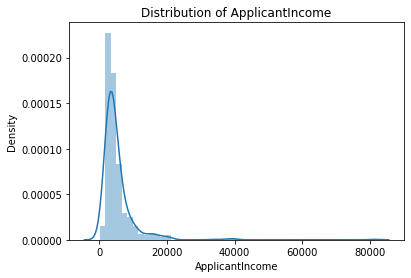

In [ ]:
# whille checking distributions we noticed that distribution of ApplicantIncome 
# is not as normal as it could be 
sns.distplot(data.ApplicantIncome)
plt.title("Distribution of ApplicantIncome")
plt.show()

In [ ]:
# transforming it into logarithm
data.ApplicantIncome = np.log(data.ApplicantIncome)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


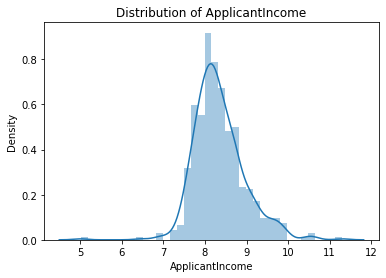

In [ ]:
# checking distribution one more time; now it's normal
sns.distplot(data.ApplicantIncome)
plt.title("Distribution of ApplicantIncome")
plt.show()

Model 2 | Logistic Regression with Statsmodels

In [ ]:
# defining dependent and independent variables 
# with the help of backward selection, removing one by one insignificant variables 
# including already transformed to logarithm ApplicantIncome variable 
Y = data["Loan_Status"]
X = data[["ApplicantIncome","Credit_History","Married_Yes","Education_Not Graduate",
                   "Property_Area_Semiurban"]]

In [ ]:
# checking shape of X: 566 observations, and 5 independent variables
X.shape

(566, 5)

In [ ]:
# splitting the data into train and test (25% threshold)
X0, X1, Y0, Y1 = train_test_split(X, Y, test_size = 0.25, random_state=42)

In [ ]:
# building and fitting Logistic Regression Model 2
model2 = Logit(Y0, X0)
results = model2.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.459936
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            Loan_Status   No. Observations:                  424
Model:                          Logit   Df Residuals:                      419
Method:                           MLE   Df Model:                            4
Date:                Mon, 17 May 2021   Pseudo R-squ.:                  0.2749
Time:                        11:27:21   Log-Likelihood:                -195.01
converged:                       True   LL-Null:                       -268.95
Covariance Type:            nonrobust   LLR p-value:                 5.819e-31
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
ApplicantIncome            -0.3450      0.057     -6.033      0.000      -0.457      -0.233
Credit_History              3.7701      0.460      8.187      0.000       2.868       4.673
Married_Yes                 0.5255      0.258      2.037      0.042       0.020       1.031
Education_Not Graduate     -0.5422      0.281     -1.926      0.054      -1.094       0.009
Property_Area_Semiurban     0.8060      0.275      2.929      0.003       0.267       1.345
===========================================================================================
"""

In [ ]:
results.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:            Loan_Status
Method:                          dydx
At:                           overall
===========================================================================================
                             dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
ApplicantIncome            -0.0505      0.007     -6.782      0.000      -0.065      -0.036
Credit_History              0.5523      0.050     11.038      0.000       0.454       0.650
Married_Yes                 0.0770      0.037      2.061      0.039       0.004       0.150
Education_Not Graduate     -0.0794      0.041     -1.948      0.051      -0.159       0.001
Property_Area_Semiurban     0.1181      0.040      2.989      0.003       0.041       0.195
===========================================================================================
"""

In [ ]:
# doing predictions 
Y1_hat=results.predict(X1)
Y0_hat=results.predict(X0)

In [ ]:
# setting threshold as 0.5
# in case of our Y0_hat and Y1_hat being predicted more than 0.5, it will be
# classified as 1, else 0
threshold = 0.5
Y0_class = np.where(Y0_hat > threshold, 1, 0)
Y1_class = np.where(Y1_hat> threshold, 1, 0)

In [ ]:
# printing ROC AUC score for Model 2 
# we see that we improved our model, now it overfits less
# this is our winning model
print("ROC AUC Model 2 train:", roc_auc_score(Y0, Y0_hat))
print("ROC AUC Model 2 test:", roc_auc_score(Y1, Y1_hat))

ROC AUC Model 2 train: 0.789826458752515
ROC AUC Model 2 test: 0.736589068825911


In [ ]:
# creating confusion matrix for train set
cm_train = confusion_matrix(Y0, Y0_class).T
print(cm_train)

[[ 64   5]
 [ 76 279]]


In [ ]:
# calculating overall accuracy, recall, and specificity for train set
print("Accuracy_train:", (cm_train[0,0]+cm_train[1,1])/len(Y0))
print("Sensitivity_train:",cm_train[1,1]/(cm_train[1,1]+cm_train[0,1]))
print("Specificity_train:",cm_train[0,0]/(cm_train[0,0]+cm_train[1,0]))

Accuracy_train: 0.8089622641509434
Sensitivity_train: 0.9823943661971831
Specificity_train: 0.45714285714285713


In [ ]:
# creating confusion matrix for test set
cm_test = confusion_matrix(Y1,Y1_class).T
print(cm_test)

[[14  5]
 [24 99]]


In [ ]:
# calculating overall accuracy, recall, and specificity for test set
print("Accuracy_test:", (cm_test[0,0]+cm_test[1,1])/len(Y1))
print("Sensitivity_test:",cm_test[1,1]/(cm_test[1,1]+cm_test[0,1]))
print("Specificity_test:",cm_test[0,0]/(cm_test[0,0]+cm_test[1,0]))

Accuracy_test: 0.795774647887324
Sensitivity_test: 0.9519230769230769
Specificity_test: 0.3684210526315789


In [ ]:
# calculating everything with the help of classification report
print("Logistic Regression Train:")
print(classification_report(Y0,Y0_class))
print("Logistic Regression Test:")
print(classification_report(Y1,Y1_class))

Logistic Regression Train:
              precision    recall  f1-score   support

           0       0.93      0.46      0.61       140
           1       0.79      0.98      0.87       284

    accuracy                           0.81       424
   macro avg       0.86      0.72      0.74       424
weighted avg       0.83      0.81      0.79       424

Logistic Regression Test:
              precision    recall  f1-score   support

           0       0.74      0.37      0.49        38
           1       0.80      0.95      0.87       104

    accuracy                           0.80       142
   macro avg       0.77      0.66      0.68       142
weighted avg       0.79      0.80      0.77       142



In [ ]:
# setting up the needed metrics
FPR, TPR, thresholds=roc_curve(Y1, Y1_hat)

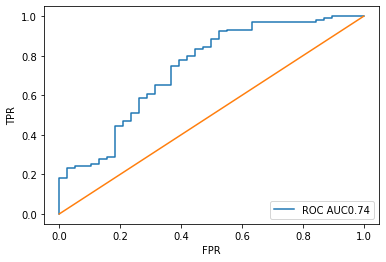

In [ ]:
# plotting ROC AUC curve for Model 2
plt.plot(FPR, TPR, label=f"ROC AUC{roc_auc_score(Y1, Y1_hat).round(2)}")
plt.plot([0,1],[0,1])
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

Model 3 | Hyperparameter tuning and CV for Logistic Regression

In [ ]:
# building GridSearch with Logistic Regression
logit_1 = LogisticRegression(random_state=42)
param_logit = {'class_weight':[None,'balanced'],
            'C':np.linspace(1,10,50),
            'penalty':['l1', 'l2', 'elasticnet', 'none']}
gridsearch = GridSearchCV(estimator=LogisticRegression(random_state = 42,n_jobs = -1),
                        param_grid=param_logit,
                        cv=5,scoring='roc_auc',verbose=1,n_jobs = -1)

In [ ]:
# fitting GridSearch
gridsearch.fit(X, Y)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 1402 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   55.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=-1, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([ 1.        ,  1.18367347,  1.36734694...
        6.51020408,  6.69387755,  6.87755102,  7.06122449,  7.24489796,
        7.42857143,  7.6122449 ,  7.79591837,  7.97959184,  8.16326531,
        8.34693878,  8.53061224,  8.71428571,  8.89795918,  9.08163265,
        9.26530612,  9.44897959,  9.63265306,  9.81632653, 10.  

In [ ]:
# understanding what the best parameters are
best_params = gridsearch.best_params_
best_params

{'C': 1.9183673469387754, 'class_weight': 'balanced', 'penalty': 'l2'}

In [ ]:
# building Logistic Regression with the best parameters
model3 = LogisticRegression(class_weight=best_params['class_weight'],C=best_params['C'],
                          penalty = best_params['penalty'],random_state = 42,n_jobs = -1).fit(X0,Y0)
Y0_prob = model3.predict_proba(X0)[:,-1]
Y1_prob = model3.predict_proba(X1)[:,-1]
Y0_class=Y0_prob>0.5
Y1_class=Y1_prob>0.5

In [ ]:
# printing ROC AUC score for Model 3 
print("ROC AUC Model 3 train:",roc_auc_score(Y0,Y0_prob))
print("ROC AUC Model 3 test:",roc_auc_score(Y1,Y1_prob))

ROC AUC Model 3 train: 0.7903043259557344
ROC AUC Model 3 test: 0.7279858299595141


In [ ]:
# getting CV scores
CV_scores = cross_val_score(model3,X,Y,cv=5,scoring="roc_auc")
print(CV_scores)

[0.79665242 0.67692308 0.76391941 0.82972583 0.78499278]


In [ ]:
# printing Mean 5-fold ROC AUC score for Model 3
print("Mean 5-fold ROC AUC score for Model 3:", np.mean(CV_scores))

Mean 5-fold ROC AUC score for Model 3: 0.7704427054427054


In [ ]:
# creating confusion matrix for train set
cm_train = confusion_matrix(Y0, Y0_class).T
print(cm_train)

[[ 73  25]
 [ 67 259]]


In [ ]:
# calculating overall accuracy, recall, and specificity for train set
print("Accuracy_train:", (cm_train[0,0]+cm_train[1,1])/len(Y0))
print("Sensitivity_train:",cm_train[1,1]/(cm_train[1,1]+cm_train[0,1]))
print("Specificity_train:",cm_train[0,0]/(cm_train[0,0]+cm_train[1,0]))

Accuracy_train: 0.7830188679245284
Sensitivity_train: 0.9119718309859155
Specificity_train: 0.5214285714285715


In [ ]:
# creating confusion matrix for test set
cm_test=confusion_matrix(Y1,Y1_class).T

In [ ]:
# calculating overall accuracy, recall, and specificity for test set
print("Accuracy_test:", (cm_test[0,0]+cm_test[1,1])/len(Y1))
print("Sensitivity_test:",cm_test[1,1]/(cm_test[1,1]+cm_test[0,1]))
print("Specificity_test:",cm_test[0,0]/(cm_test[0,0]+cm_test[1,0]))

Accuracy_test: 0.7887323943661971
Sensitivity_test: 0.9326923076923077
Specificity_test: 0.39473684210526316


In [ ]:
# calculating everything with the help of classification report
print("Logistic Regression Train:")
print(classification_report(Y0,Y0_class))
print("Logistic Regression Test:")
print(classification_report(Y1,Y1_class))

Logistic Regression Train:
              precision    recall  f1-score   support

           0       0.74      0.52      0.61       140
           1       0.79      0.91      0.85       284

    accuracy                           0.78       424
   macro avg       0.77      0.72      0.73       424
weighted avg       0.78      0.78      0.77       424

Logistic Regression Test:
              precision    recall  f1-score   support

           0       0.68      0.39      0.50        38
           1       0.81      0.93      0.87       104

    accuracy                           0.79       142
   macro avg       0.75      0.66      0.68       142
weighted avg       0.77      0.79      0.77       142



In [ ]:
# setting up the needed metrics
FPR, TPR, thresholds=roc_curve(Y1, Y1_prob)

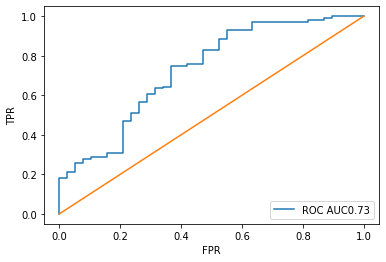

In [ ]:
# plotting ROC AUC curve for Model 3
plt.plot(FPR, TPR, label=f"ROC AUC{roc_auc_score(Y1, Y1_prob).round(2)}")
plt.plot([0,1],[0,1])
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

Model 4 | Decision Tree Classification | Fully Grown DT

In [ ]:
# building and fitting Model 4 with Decision Tree Classifier
model4 = DecisionTreeClassifier(random_state=42)
model4.fit(X0,Y0)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
# calculating and getting probabilities 
Y0_dt = model4.predict_proba(X0)[:,1]
Y1_dt = model4.predict_proba(X1)[:,1]

In [ ]:
# printing ROC AUC score for Model 4
# even though the train set performs well, we have a huge overfitting 
print("ROC AUC for Model 4 train:",roc_auc_score(Y0,Y0_dt))
print("ROC AUC for Model 4 test:",roc_auc_score(Y1,Y1_dt))

ROC AUC for Model 4 train: 0.9999371227364185
ROC AUC for Model 4 test: 0.697494939271255


Model 5 | Decision Tree Classification | Manual DT

In [ ]:
# building and fitting Model 5 with Decision Tree Classifier by manually setting up
# hypermparameter values
model5 = DecisionTreeClassifier(random_state=42, max_depth=10,min_samples_leaf=200)
model5.fit(X0,Y0)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
# calculating and getting probabilities 
Y0_dt1 = model5.predict_proba(X0)[:,1]
Y1_dt1 = model5.predict_proba(X1)[:,1]

In [ ]:
# printing ROC AUC score for Model 5
# we may see the following pattern: there is almost no overfitting, however, 
# the results for our train test drastically dicreased 
print("ROC AUC for Model 5 train:",roc_auc_score(Y0,Y0_dt1))
print("ROC AUC for Model 5 test:",roc_auc_score(Y1,Y1_dt1))

ROC AUC for Model 5 train: 0.5229879275653924
ROC AUC for Model 5 test: 0.4951923076923077


Model 6 | Decision Tree Classification | Tuned DT with GridSearch

In [ ]:
# setting up the ranges for hyperparameters
param_dt = {"max_depth":range(1,15),"min_samples_leaf":range(10,150,10),
          "class_weight":["balanced", None]}

In [ ]:
# building GridSearch with Decision Tree Classification and fitting it  
gs_dt = GridSearchCV(estimator=model4,param_grid=param_dt,scoring="roc_auc",cv=5,n_jobs=-1)
gs_dt.fit(X,Y)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                     

In [ ]:
# understanding what the best parameters are
best_params = gs_dt.best_params_
best_params

{'class_weight': None, 'max_depth': 7, 'min_samples_leaf': 20}

In [ ]:
# building Decision Tree Classification with the best parameters
model6 = DecisionTreeClassifier(class_weight=best_params['class_weight'],max_depth=best_params['max_depth'],
                             min_samples_leaf=best_params['min_samples_leaf'], random_state=42).fit(X0,Y0)
Y0_dt_grid = model6.predict_proba(X0)[:,1]
Y1_dt_grid = model6.predict_proba(X1)[:,1]
Y0_class=Y0_prob>0.5
Y1_class=Y1_prob>0.5

In [ ]:
# printing ROC AUC score for Model 6 
print("ROC AUC score for train:",roc_auc_score(Y0,Y0_dt_grid))
print("ROC AUC score for test:",roc_auc_score(Y1,Y1_dt_grid))

ROC AUC score for train: 0.8497987927565392
ROC AUC score for test: 0.6818066801619432


In [ ]:
# printing Mean 5-fold ROC AUC score for Model 6
print("Mean 5-fold ROC AUC score for Model 6:",np.mean(cross_val_score(estimator=model6, X=X,y=Y,cv=5, scoring="roc_auc")))

Mean 5-fold ROC AUC score for Model 6: 0.7548658748658749


In [ ]:
# reviewing feature importances of the winning model
feat_imp = pd.DataFrame(model6.feature_importances_,index=X.columns,
                      columns=["Feature_imp"])
feat_imp = feat_imp.sort_values(by="Feature_imp",ascending=False)
feat_imp.head(5)

,Feature_imp
Credit_History,0.808483
ApplicantIncome,0.116326
Married_Yes,0.043689
Property_Area_Semiurban,0.031502
Education_Not Graduate,0.000000


In [ ]:
# setting up the needed metrics
FPR, TPR, thresholds=roc_curve(Y1, Y1_dt_grid)

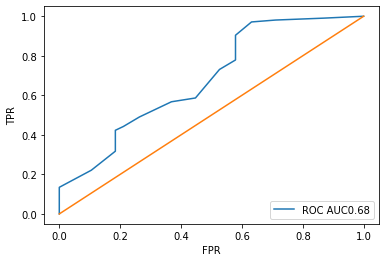

In [ ]:
# plotting ROC AUC curve for Model 6
plt.plot(FPR, TPR, label=f"ROC AUC{roc_auc_score(Y1, Y1_dt_grid).round(2)}")
plt.plot([0,1],[0,1])
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

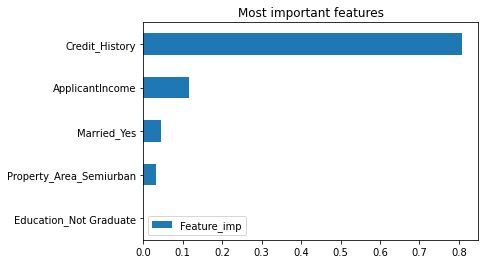

In [ ]:
# visualizing feature importances
feat_imp.head(5).sort_values('Feature_imp').plot.barh()
plt.title("Most important features")
plt.show()

Model 7 | Decision Tree Classification | Removing 0 feature importances

In [ ]:
# removing feature importances equal to 0 to see whether the model will perform 
# better 
to_remove = feat_imp[feat_imp.Feature_imp==0].index
print(to_remove)

Index(['Education_Not Graduate'], dtype='object')


In [ ]:
# building Decision Tree Classification with the best parameters
model7 = DecisionTreeClassifier(class_weight=best_params['class_weight'],max_depth=best_params['max_depth'],
                             min_samples_leaf=best_params['min_samples_leaf'], random_state=42).fit(X0.drop(to_remove,axis=1),Y0)

Y0_dt_grid1 = model7.predict_proba(X0.drop(to_remove,axis=1))[:,1]
Y1_dt_grid1 = model7.predict_proba(X1.drop(to_remove,axis=1))[:,1]

In [ ]:
# printing ROC AUC score for Model 7 
# we see that the results from removing Education_Not_Graduate remained the same
print("ROC_AUC Train:",roc_auc_score(Y0,Y0_dt_grid1))
print("ROC_AUC Test:",roc_auc_score(Y1,Y1_dt_grid1))

ROC_AUC Train: 0.8497987927565392
ROC_AUC Test: 0.6818066801619432


In [ ]:
# printing Mean 5-fold ROC AUC score for Model 7
print("Mean 5-fold ROC AUC score for Model 7:",np.mean(cross_val_score(estimator=model6, X=X,y=Y,cv=5, scoring="roc_auc")))

Mean 5-fold ROC AUC score for Model 6: 0.7548658748658749
